# Artificial Neural Networks and Deep Learning

---

## SiumGPT Homework 2 Final Notebook (Model 1)

## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ["SM_FRAMEWORK"] = "tf.keras"
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd
from datetime import datetime

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import albumentations as A
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
from keras.utils import to_categorical
from keras.saving import load_model
from keras.metrics import MeanIoU
from keras import saving as ks

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

!pip install -U segmentation-models
import segmentation_models as sm

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.16.1
TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⚙️ Functions

### Plots and Data Visualizations

In [ ]:
# Define the values and corresponding colors
values = [0, 1, 2, 3, 4]
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Create colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(values + [5], cmap.N)  # Add a boundary for the last value

In [ ]:
def plot_images(images, masks, num_samples=3):
    """
    Visualizes a random subset of images and their corresponding masks.

    Args:
        images (np.ndarray): Array of input images.
        masks (np.ndarray): Array of corresponding ground truth masks.
        num_samples (int): Number of samples to visualize. Default is 3.
    """
    random_indices = np.random.choice(len(images), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    for i, idx in enumerate(random_indices):
        axes[i, 0].imshow(images[idx], cmap='gray')
        axes[i, 0].set_title(f"Image {idx}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[idx], cmap=cmap, norm=norm)
        axes[i, 1].set_title(f"Label {idx}")
        axes[i, 1].axis('off')

    plt.tight_layout()

In [ ]:
def plot_training_history(history):
    """
    Plots training and validation metrics over epochs from the training history.

    Args:
        history (dict): Dictionary containing training metrics like 'loss', 'accuracy', and 'meaniou',
                        as well as their validation counterparts (e.g., 'val_loss').
    """
    # Plot and display training and validation loss
    plt.figure(figsize=(18, 3))
    plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Cross Entropy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot and display training and validation accuracy
    plt.figure(figsize=(18, 3))
    plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot and display training and validation mean IoU
    plt.figure(figsize=(18, 3))
    plt.plot(history['meaniou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_meaniou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Mean Intersection over Union')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

### Augmentations

In [ ]:
def apply_augmentations(images, masks, aug_list):
    """
    Applies a list of augmentations to images and masks, returning the augmented data.

    Args:
        images (np.ndarray): Array of input images.
        masks (np.ndarray): Array of corresponding ground truth masks.
        aug_list (list): List of augmentation functions to apply.

    Returns:
        dict: Dictionary containing augmented images under key "images" and augmented masks under key "labels".
    """
    augmented_images = []
    augmented_masks = []

    for aug in aug_list:
        for img, mask in zip(images, masks):
            augmented = aug(image=img, mask=mask)
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'])

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    return {"images":augmented_images, "labels":augmented_masks}

### Class Weights, Sample Weights and Data Distribution

In [ ]:
def compute_class_distribution(masks, num_classes):
    """
    Compute the distribution of classes in the given masks.

    Args:
        masks (np.array): Array of ground truth masks (e.g., shape: (batch, height, width)).
        num_classes (int): Total number of classes in the dataset.

    Returns:
        tuple: A dictionary with class counts and another dictionary with percentage distribution.
    """
    # Flatten all masks into a 1D array to count pixel occurrences
    flat_masks = masks.flatten()

    # Count the occurrences of each class label
    class_counts = Counter(flat_masks)

    # Calculate total number of pixels
    total_pixels = flat_masks.size

    # Calculate percentage distribution
    percentages = {label: (count / total_pixels) * 100 for label, count in class_counts.items()}

    return class_counts, percentages

In [ ]:
def compute_class_weights_from_dict(class_percentage_dict):
    """
    Compute class weights based on class percentages, ignoring class 0.

    Args:
        class_percentage_dict (dict): Dictionary of class percentages.

    Returns:
        dict: A dictionary mapping class labels to weights.
    """
    # Exclude class 0 from the computation
    class_labels = list(class_percentage_dict.keys())
    class_percentages = np.array(list(class_percentage_dict.values()))

    # Identify indices for all classes except 0
    non_zero_indices = [i for i, label in enumerate(class_labels) if label != 0]

    # Get class labels and percentages for non-zero classes
    non_zero_labels = [class_labels[i] for i in non_zero_indices]
    non_zero_percentages = class_percentages[non_zero_indices]

    # Normalize percentages to sum to 1 (excluding class 0)
    class_frequencies = non_zero_percentages / np.sum(non_zero_percentages)

    # Compute inverse frequencies and scale to average 1
    inverse_frequencies = 1.0 / (class_frequencies + 1e-6)
    scaled_weights = inverse_frequencies / np.mean(inverse_frequencies)

    # Create a dictionary mapping non-zero labels to weights
    class_weights = dict(zip(non_zero_labels, scaled_weights))

    # Add class 0 with a weight of 0
    class_weights[0.0] = 0.0

    # Ensure all classes are present in the output dictionary
    for label in class_labels:
        if label not in class_weights:
            class_weights[label] = 0.0

    return class_weights

In [ ]:
def compute_sample_weights(labels, class_weights):
    """
    Compute pixel-level sample weights based on class weights.

    Args:
        labels (np.array): One-hot encoded labels (e.g., shape: (batch, height, width, num_classes)).
        class_weights (dict): Class weights mapping.

    Returns:
        np.array: Sample weights for each pixel (e.g., shape: (batch, height, width)).
    """
    # Convert the class_weights dictionary to a weight vector
    weight_vector = np.array([class_weights[class_id] for class_id in range(len(class_weights))])

    # Multiply one-hot labels with the weight vector
    weighted_labels = labels * weight_vector[np.newaxis, np.newaxis, np.newaxis, :]  # Broadcast weights

    # Sum over the class channel to get per-pixel weights
    sample_weights = np.sum(weighted_labels, axis=-1)  # Shape: (batch_size, height, width)

    return sample_weights

### Class-wise MeanIoU

In [ ]:
def calculate_classwise_miou(y_true, y_pred, num_classes):
    """
    Calculate the mean Intersection over Union (mIoU) for each class.

    Args:
        y_true (np.array): Ground truth labels (e.g., shape: (batch, height, width)).
        y_pred (np.array): Predicted labels (e.g., shape: (batch, height, width)).
        num_classes (int): Total number of classes.

    Returns:
        dict: Dictionary of IoU values for each class.
    """
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Initialize the MeanIoU object
    miou_metric = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0,)
    miou_metric.update_state(y_true_flat, y_pred_flat)

    # Extract IoU per class
    total_conf_matrix = miou_metric.total_cm.numpy()  # Get the confusion matrix
    ious = []
    for i in range(num_classes):
        TP = total_conf_matrix[i, i]  # True positives for class i
        FP = total_conf_matrix[:, i].sum() - TP  # False positives for class i
        FN = total_conf_matrix[i, :].sum() - TP  # False negatives for class i
        denominator = TP + FP + FN
        if denominator == 0:
            iou = np.nan  # Handle classes not present in predictions or labels
        else:
            iou = TP / denominator
        ious.append(iou)

    # Create a dictionary for class-wise IoU
    miou_per_class = {f"Class {i}": iou for i, iou in enumerate(ious)}
    return miou_per_class

## ⏳ Load the Data

In [ ]:
data = np.load("/kaggle/input/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# not used, just as a reference
labels = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Removing aliens
alien_label = y_train[1834, :]
#plt.imshow(alien_label, cmap='viridis')

filter = [True] * X_train.shape[0]
removed = 0
for i, lab in enumerate(y_train):
    if np.array_equal(alien_label, lab):
        filter[i] = False
        removed += 1

X_train = X_train[filter]
y_train = y_train[filter]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f'Removed {removed} images')

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Removed 110 images


In [ ]:
# Add color channel
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Augmentations
h_flip = A.HorizontalFlip(p=1.0)
v_flip = A.VerticalFlip(p=1.0)
rotation = A.Affine(rotate=180,p=1)
augmentations = [h_flip, v_flip, rotation]
aug_dataset = apply_augmentations(X_train, y_train, augmentations)
X_train, y_train = aug_dataset['images'], aug_dataset['labels']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

Training X shape: (7515, 64, 128, 1)
Training y shape: (7515, 64, 128)


Class Counts: [14330430, 14966478, 11312469, 20872614, 80889]
Class Percentages: [23.277712153817365, 24.31088019273952, 18.375470738211078, 33.90454442677145, 0.13139248846057885]
Computed Class Weights: {2.0: 0.022220544151821984, 3.0: 0.02814855680979399, 1.0: 0.015255888747690028, 4.0: 3.9343750102906943, 0.0: 0.0}


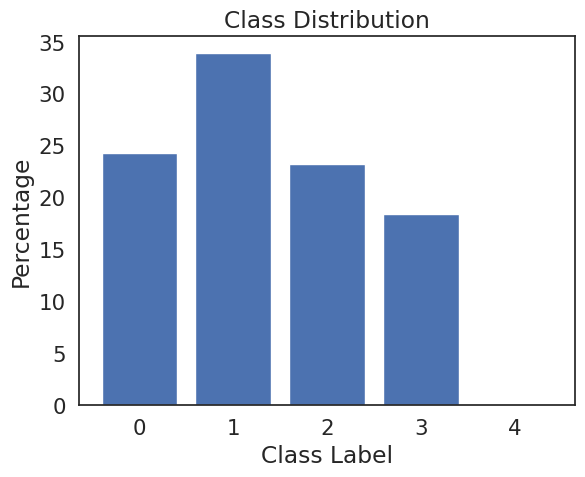

In [ ]:
class_counts, class_percentages = compute_class_distribution(y_train, num_classes)
class_weights = compute_class_weights_from_dict(class_percentages)

# Print results
print("Class Counts:", list(class_counts.values()))
print("Class Percentages:", list(class_percentages.values()))
print("Computed Class Weights:", class_weights)

# Visualize class distribution
plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Class Label')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Splitting in train-validation sets
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)
print("Data splitted!")

train_lbl_cat = tf.one_hot(train_lbl, depth=num_classes)
val_lbl_cat = tf.one_hot(val_lbl, depth=num_classes)

print(f"\nNumber of images:")
print(f"Train: {train_img.shape}")
print(f"Validation: {val_img.shape}")
print(f"\nLabels shape:")
print(f"Train: {train_lbl_cat.shape}")
print(f"Validation: {val_lbl_cat.shape}")

Data splitted!

Number of images:
Train: (6763, 64, 128, 1)
Validation: (752, 64, 128, 1)

Labels shape:
Train: (6763, 64, 128, 5)
Validation: (752, 64, 128, 5)


## 🛠️ Train and Save the Model

In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    """
    Visualization callback for displaying images, ground truth, and predictions during training.

    Args:
        image (np.array): Input image batch to visualize (e.g., shape: (batch, height, width, channels)).
        label (np.array): Ground truth masks corresponding to the input image.
        frequency (int): Frequency of visualization (in epochs).
    """
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            pred = self.model.predict(self.image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image[22], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(self.label[22], cmap=cmap, norm=norm)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[22], cmap=cmap, norm=norm)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
ks.get_custom_objects().clear()

@ks.register_keras_serializable()
class CustomLoss(tfk.losses.Loss):
    """
    Custom loss function combining Dice, Focal, and Categorical Cross-Entropy losses.

    Args:
        k_dice (float): Weight for the Dice loss component.
        k_focal (float): Weight for the Focal loss component.
        k_cat_ce (float): Weight for the Categorical Cross-Entropy loss component.
    """
    def __init__(self, k_dice, k_focal, k_cat_ce, **kwargs):
        super(CustomLoss, self).__init__()
        self.k_dice = k_dice
        self.k_focal = k_focal
        self.k_cat_ce = k_cat_ce

        self.dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4])
        self.focal_loss = sm.losses.CategoricalFocalLoss(class_indexes=[1,2,3,4])
        self.cat_ce = sm.losses.CategoricalCELoss(class_indexes=[1,2,3,4])

    def get_config(self):
        config = super().get_config()
        # Update the config with the custom layer's parameters
        config.update(
            {
                "k_dice": self.k_dice,
                "k_focal": self.k_focal,
                "k_cat_ce": self.k_cat_ce,
            }
        )
        return config

    def call(self, y_true, y_pred):
        focal = self.focal_loss(y_true, y_pred)
        dice = self.dice_loss(y_true, y_pred)
        cat_ce = self.cat_ce(y_true, y_pred)

        return self.k_dice * dice + self.k_focal * focal + self.k_cat_ce * cat_ce

## 🛠️ Train and Save the Model

In [ ]:
# Model parameters
learning_rate = 1e-3
patience = 30
batch_size = 64
epochs = 1000

optimizer = tf.keras.optimizers.AdamW(learning_rate, clipnorm=1.0)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_true=False, sparse_y_pred=False, name="meaniou")
metrics = ["accuracy", mean_iou]

# Loss function for the model
loss1 = CustomLoss(1, 1, 0)

# Computes the sample weights from the class weights
sample_weights = compute_sample_weights(train_lbl_cat, class_weights)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_meaniou',
    mode='max',
    patience=patience,
    restore_best_weights=True
)
viz_callback = VizCallback(val_img, val_lbl)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_meaniou",
    mode='max',
    factor=0.2,
    patience=20
)

## Custom W-Net

In [ ]:
def unet_down_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name='', max_pooling=True, concat_block=None):
    """
    Generates a single block of convolutional layers and max pooling for the U-Net encoder.

    Args:
        input_tensor (tf.Tensor): The input tensor to the block.
        filters (int): Number of filters for the Conv2D layers.
        kernel_size (int): Size of the convolutional kernel (default is 3).
        activation (string): Activation function to apply after each convolution (default is 'relu').
        stack (int): Number of stacked Conv2D layers within the block (default is 2).
        name (string): Base name for the layers, useful for naming consistency (default is '').
        max_pooling (bool): Boolean flag to indicate whether to apply max pooling at the end of the block (default is True).
        concat_block (list): List of tensors to concatenate with the input, for skip connections (default is None).
    """
    # Initialise the input tensor
    x = input_tensor

    # Concatenate skip connected blocks
    if concat_block is not None:
        x = tfkl.Concatenate()([x, *concat_block])

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Dropout(0.1)(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Max Pooling
    if max_pooling:
        x = tfkl.MaxPooling2D()(x)

    # Return the transformed tensor
    return x

def unet_up_block(input_tensor, filters, concat_block, kernel_size=3, activation='relu', stack=2, name=''):
    """
    Generates a single block of transposed convolutional layers and concatenation for the U-Net decoder.

    Args:
        input_tensor (tf.Tensor): The input tensor to the block.
        filters (int): Number of filters for the Conv2DTranspose layers.
        concat_block (list): Tensor to concatenate with the input tensor for skip connections.
        kernel_size (int): Size of the convolutional kernel (default is 3).
        activation (str): Activation function to apply after each convolution (default is 'relu').
        stack (int): Number of stacked Conv2D layers within the block (default is 2).
        name (string): Base name for the layers, useful for naming consistency (default is '').
    """

    # Initialise the input tensor
    x = input_tensor

    # Up-sampling
    x = tfkl.UpSampling2D()(x)

    # Concatenate skip connected blocks
    if concat_block is not None:
        x = tfkl.Concatenate()([x, *concat_block])

    # Apply convolutions, bn, activations
    x = unet_down_block(x, filters, kernel_size, activation, stack, name=name, max_pooling=False)

    # Return the transformed tensor
    return x

def feature_fusion_model(inputs, filters=1, kernel_size=3, activation='relu'):
    """
    Creates a feature fusion model that combines multiple input feature maps into a single output.

    Args:
        inputs: List of input tensors to the model.
        filters: Number of filters for the Conv2D layers applied to each input tensor (default is 1).
        kernel_size: Size of the convolutional kernel (default is 3).
        activation: Activation function to apply after each convolution (default is 'relu').
    """

    # Convolution block and up-sampling (bilinear interpolation) of every input
    conv_inputs = []
    for i, inp in enumerate(inputs):

        # Convolutional block
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=f'ams_conv_{i}')(inp)
        x = tfkl.BatchNormalization(name=f'ams_bn_{i}')(x)
        x = tfkl.Dropout(0.1)(x)
        x = tfkl.Activation(activation, name=f'ams_activation_{i}')(x)

        # Up-sampling
        upscale_factor = int(64 / inp.shape[1])
        if upscale_factor != 1:
            x = tfkl.UpSampling2D(size=upscale_factor, interpolation='bilinear')(x)
        conv_inputs.append(x)

    # Feature concatenation
    x = tfkl.Concatenate()(conv_inputs)

    # Final 1x1 convolution + softmax
    x = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='net2_output_layer')(x)

    # Return the outpu
    return x

In [ ]:
def get_wnet_model(input_shape=(64, 128, 1), num_classes=5, num_filters=[32, 64, 128, 256, 512], seed=seed):
    """
    Creates the W-Net model, with fully connected paths (all forward skip-connections between features of the same activation
    size), and a feature fusion model.

    Args:
        input_shape (list[int]): shape of the input tensor (defaults to 64x128 grayscale)
        num_classes (int): number of classes in the mask (defaults to our segmentation classes, 5)
        num_filters (list[int]): number of filters for the blocks in the encoder paths, the decoders will have the same number
            of filters, in reverted order. The last value is the one corresponding to the bottleneck's number of filters
        seed (int): RNG seed
    """

    # Set random seed
    tf.random.set_seed(seed)

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Lists of layers
    down_layers = []
    up_layers = []
    down_layers_2 = []
    up_layers_2 = []

    ################## First U-Net ##################
    x = input_layer
    down_layers.append(x)

    # Downsampling path
    for i, filters in list(enumerate(num_filters))[:-1]:
        x = unet_down_block(x, filters=filters, name=f'down_block{i+1}_')
        down_layers.append(x)

    # Bottleneck
    x = unet_down_block(x, filters=num_filters[-1], name='bottleneck_')
    down_layers.append(x)

    # Upsampling path
    for i, filters in list(enumerate(num_filters))[:-1][::-1]:
        x = unet_up_block(x, filters=filters, concat_block=[down_layers[i+1]], name=f'up_block{len(num_filters) - i}_')
        up_layers.append(x)

    # Output Layer
    x = unet_up_block(x, filters=16, concat_block=[input_layer], name=f'up_block{len(num_filters)+1}_')
    up_layers.append(x)
    output_layer = x

    ################## Second U-Net ##################

    # Input of the second net is the output of the first
    x = output_layer
    down_layers_2.append(x)

    # Downsampling path
    for i, filters in list(enumerate(num_filters))[:-1]:
        x = unet_down_block(x, filters=filters, concat_block=[down_layers[i], up_layers[::-1][i]], name=f'net2_down_block{i+1}_')
        down_layers_2.append(x)

    # Bottleneck
    x = unet_down_block(x, filters=num_filters[-1], name='net2_bottleneck_')
    down_layers_2.append(x)

    # Upsampling path
    for i, filters in list(enumerate(num_filters))[:-1][::-1]:
        x = unet_up_block(x, filters=filters, concat_block=[down_layers[i+1], up_layers[::-1][i+1], down_layers_2[i+1]], name=f'net2_up_block{len(num_filters) - i}_')
        up_layers_2.append(x)

    # Output Layer
    x = unet_up_block(x, filters=16, concat_block=[down_layers_2[0],down_layers[0]], name=f'net2_up_block{len(num_filters)+1}_')
    up_layers_2.append(x)

    ################## Feature Fusion ##################
    ams_output = feature_fusion_model(inputs=[*up_layers_2, output_layer])

    # Construct Model
    model = tf.keras.Model(inputs=input_layer, outputs=ams_output, name='WNet')

    # Return the model
    return model

### Model 1 (Dice + Focal Loss)

(None, 2, 4, 512)
(None, 4, 8, 512)
(None, 4, 8, 256)
(None, 8, 16, 256)
(None, 8, 16, 128)
(None, 16, 32, 128)
(None, 16, 32, 64)
(None, 32, 64, 64)
(None, 32, 64, 32)
(None, 64, 128, 32)
<KerasTensor shape=(None, 64, 128, 1), dtype=float32, sparse=None, name=input_layer>
<KerasTensor shape=(None, 32, 64, 32), dtype=float32, sparse=False, name=keras_tensor_8>
<KerasTensor shape=(None, 16, 32, 64), dtype=float32, sparse=False, name=keras_tensor_17>
<KerasTensor shape=(None, 8, 16, 128), dtype=float32, sparse=False, name=keras_tensor_26>
<KerasTensor shape=(None, 4, 8, 256), dtype=float32, sparse=False, name=keras_tensor_35>
<KerasTensor shape=(None, 2, 4, 512), dtype=float32, sparse=False, name=keras_tensor_44>
<KerasTensor shape=(None, 4, 8, 256), dtype=float32, sparse=False, name=keras_tensor_54>
<KerasTensor shape=(None, 8, 16, 128), dtype=float32, sparse=False, name=keras_tensor_64>
<KerasTensor shape=(None, 16, 32, 64), dtype=float32, sparse=False, name=keras_tensor_74>
<KerasTens

Model: "WNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        320 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ dropout[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv2   │ (None, 64, 128,   │      9,248 │ down_block1_acti… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn2     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128,   │          0 │ down_block1_bn2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ dropout_1[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     18,496 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ dropout_2[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv2   │ (None, 32, 64,    │     36,928 │ down_block2_acti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn2     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 64,    │          0 │ down_block2_bn2[

 Total params: 18,087,137 (69.00 MB)

 Trainable params: 18,075,221 (68.95 MB)

 Non-trainable params: 11,916 (46.55 KB)

None


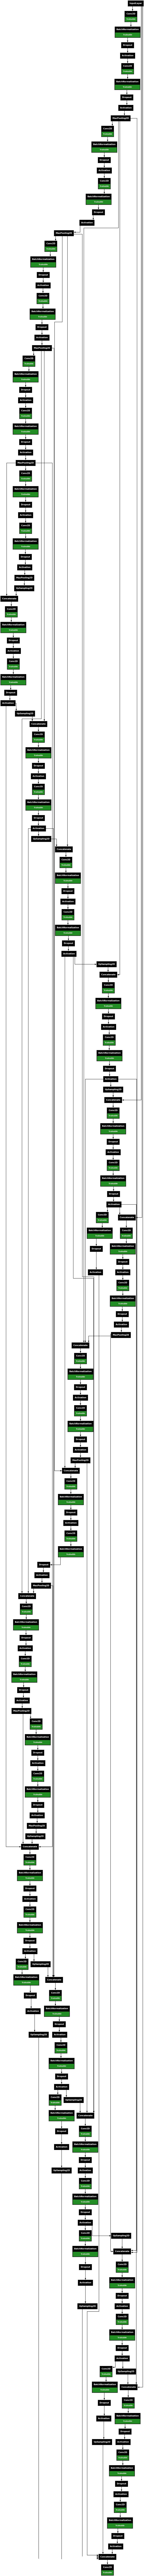

In [ ]:
model = get_wnet_model()
print(model.summary())
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Epoch 1/1000


I0000 00:00:1733856141.181394      73 service.cc:145] XLA service 0x7a69e00035a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733856141.181456      73 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733856286.308782      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3904 - loss: 0.0153 - meaniou: 0.2219   

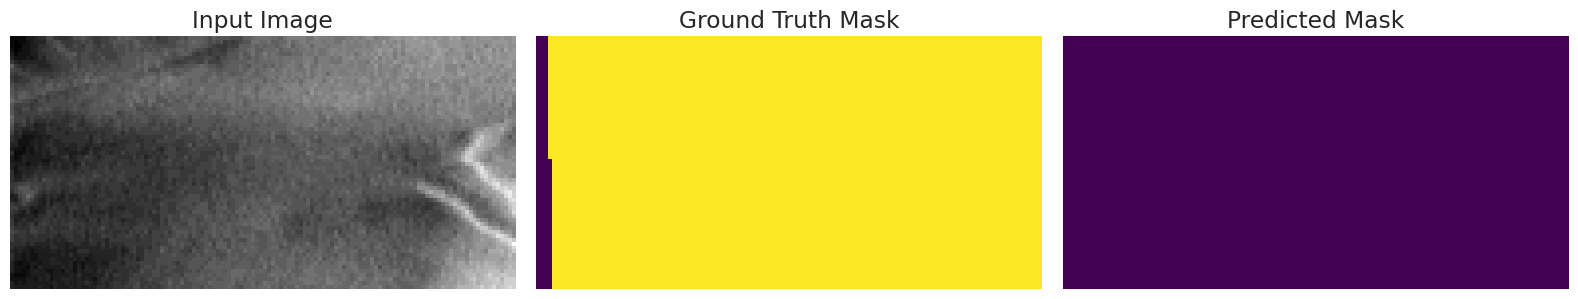

106/106 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.3911 - loss: 0.0153 - meaniou: 0.2224 - val_accuracy: 0.3843 - val_loss: 1.0060 - val_meaniou: 0.1791 - learning_rate: 0.0010
Epoch 2/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5700 - loss: 0.0123 - meaniou: 0.4533 - val_accuracy: 0.4066 - val_loss: 0.7821 - val_meaniou: 0.2679 - learning_rate: 0.0010
Epoch 3/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6056 - loss: 0.0111 - meaniou: 0.4986 - val_accuracy: 0.3570 - val_loss: 0.8715 - val_meaniou: 0.2375 - learning_rate: 0.0010
Epoch 4/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6168 - loss: 0.0106 - meaniou: 0.5128 - val_accuracy: 0.3971 - val_loss: 0.8729 - val_meaniou: 0.2664 - learning_rate: 0.0010
Epoch 5/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6251 - loss: 0.0102 - meaniou: 0.5260 - val_accuracy: 0.3713 - val_loss: 0.8222 - val_meaniou: 0.2417 - learning_rate: 0.0010
Epoch 6/1000
106/106 ━━━━━━━━━

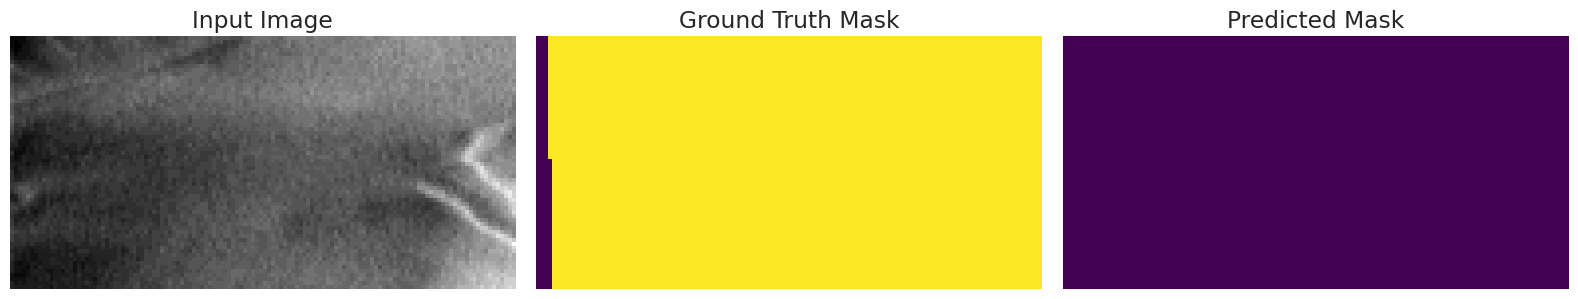

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.6288 - loss: 0.0101 - meaniou: 0.5301 - val_accuracy: 0.6184 - val_loss: 0.5216 - val_meaniou: 0.5158 - learning_rate: 0.0010
Epoch 7/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6497 - loss: 0.0096 - meaniou: 0.5607 - val_accuracy: 0.5528 - val_loss: 0.5909 - val_meaniou: 0.4380 - learning_rate: 0.0010
Epoch 8/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6493 - loss: 0.0095 - meaniou: 0.5601 - val_accuracy: 0.4919 - val_loss: 0.6381 - val_meaniou: 0.3628 - learning_rate: 0.0010
Epoch 9/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6479 - loss: 0.0096 - meaniou: 0.5580 - val_accuracy: 0.6147 - val_loss: 0.5128 - val_meaniou: 0.5145 - learning_rate: 0.0010
Epoch 10/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6572 - loss: 0.0093 - meaniou: 0.5722 - val_accuracy: 0.5869 - val_loss: 0.5481 - val_meaniou: 0.4702 - learning_rate: 0.0010
Epoch 11/1000
106/106 ━━━━━

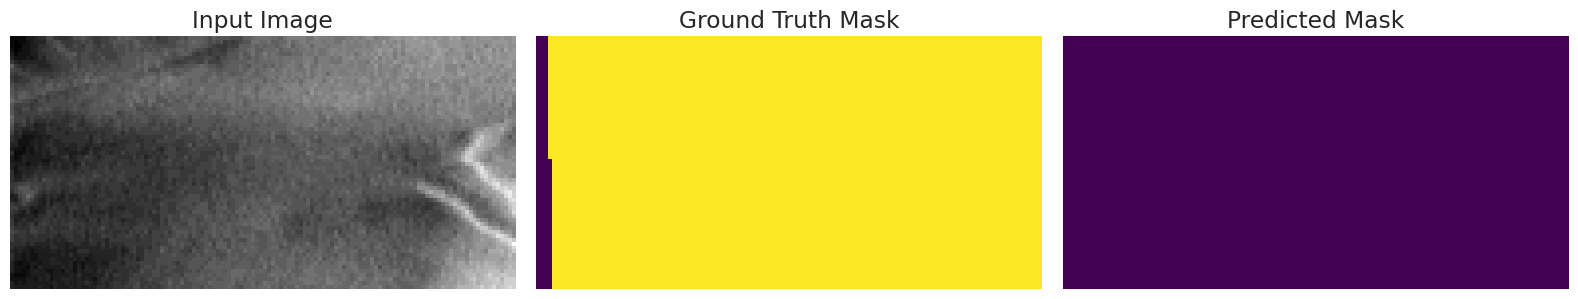

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.6588 - loss: 0.0092 - meaniou: 0.5751 - val_accuracy: 0.6370 - val_loss: 0.4898 - val_meaniou: 0.5415 - learning_rate: 0.0010
Epoch 12/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6651 - loss: 0.0091 - meaniou: 0.5838 - val_accuracy: 0.5575 - val_loss: 0.5916 - val_meaniou: 0.4289 - learning_rate: 0.0010
Epoch 13/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6675 - loss: 0.0091 - meaniou: 0.5874 - val_accuracy: 0.5149 - val_loss: 0.6644 - val_meaniou: 0.3649 - learning_rate: 0.0010
Epoch 14/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.6680 - loss: 0.0090 - meaniou: 0.5882 - val_accuracy: 0.6553 - val_loss: 0.4674 - val_meaniou: 0.5665 - learning_rate: 0.0010
Epoch 15/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6735 - loss: 0.0089 - meaniou: 0.5973 - val_accuracy: 0.5809 - val_loss: 0.5636 - val_meaniou: 0.4635 - learning_rate: 0.0010
Epoch 16/1000
106/106 ━━

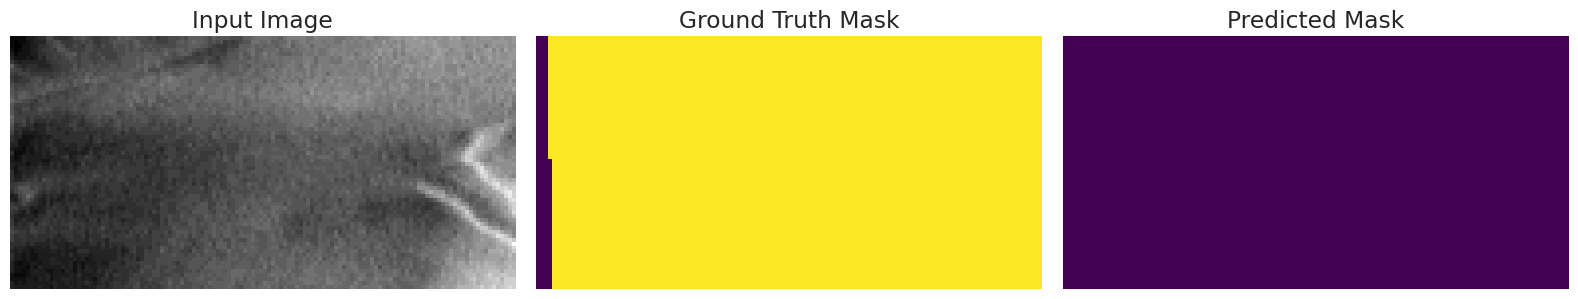

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.6770 - loss: 0.0088 - meaniou: 0.6087 - val_accuracy: 0.5369 - val_loss: 0.6421 - val_meaniou: 0.4170 - learning_rate: 0.0010
Epoch 17/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6743 - loss: 0.0088 - meaniou: 0.6154 - val_accuracy: 0.5408 - val_loss: 0.6160 - val_meaniou: 0.4170 - learning_rate: 0.0010
Epoch 18/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.6693 - loss: 0.0090 - meaniou: 0.6017 - val_accuracy: 0.5959 - val_loss: 0.5421 - val_meaniou: 0.4838 - learning_rate: 0.0010
Epoch 19/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.6828 - loss: 0.0087 - meaniou: 0.6219 - val_accuracy: 0.6312 - val_loss: 0.5075 - val_meaniou: 0.5495 - learning_rate: 0.0010
Epoch 20/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.6794 - loss: 0.0087 - meaniou: 0.6304 - val_accuracy: 0.5952 - val_loss: 0.5351 - val_meaniou: 0.4969 - learning_rate: 0.0010
Epoch 21/1000
106/106 ━━

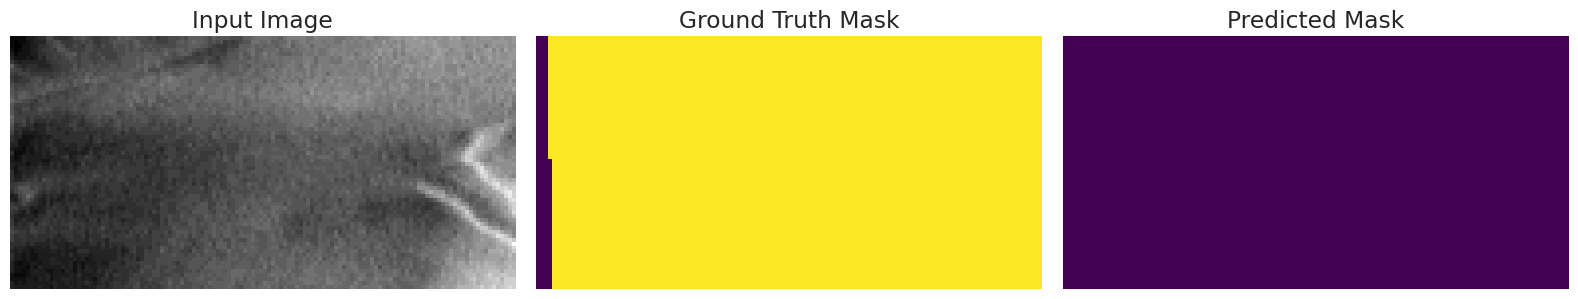

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.6798 - loss: 0.0086 - meaniou: 0.6233 - val_accuracy: 0.6138 - val_loss: 0.5147 - val_meaniou: 0.5261 - learning_rate: 0.0010
Epoch 22/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.6800 - loss: 0.0086 - meaniou: 0.6286 - val_accuracy: 0.6013 - val_loss: 0.5338 - val_meaniou: 0.5122 - learning_rate: 0.0010
Epoch 23/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.6864 - loss: 0.0084 - meaniou: 0.6469 - val_accuracy: 0.6747 - val_loss: 0.4477 - val_meaniou: 0.6119 - learning_rate: 0.0010
Epoch 24/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.6833 - loss: 0.0085 - meaniou: 0.6397 - val_accuracy: 0.6447 - val_loss: 0.4896 - val_meaniou: 0.5627 - learning_rate: 0.0010
Epoch 25/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.6904 - loss: 0.0083 - meaniou: 0.6435 - val_accuracy: 0.6591 - val_loss: 0.4708 - val_meaniou: 0.5768 - learning_rate: 0.0010
Epoch 26/1000
106/106 ━━

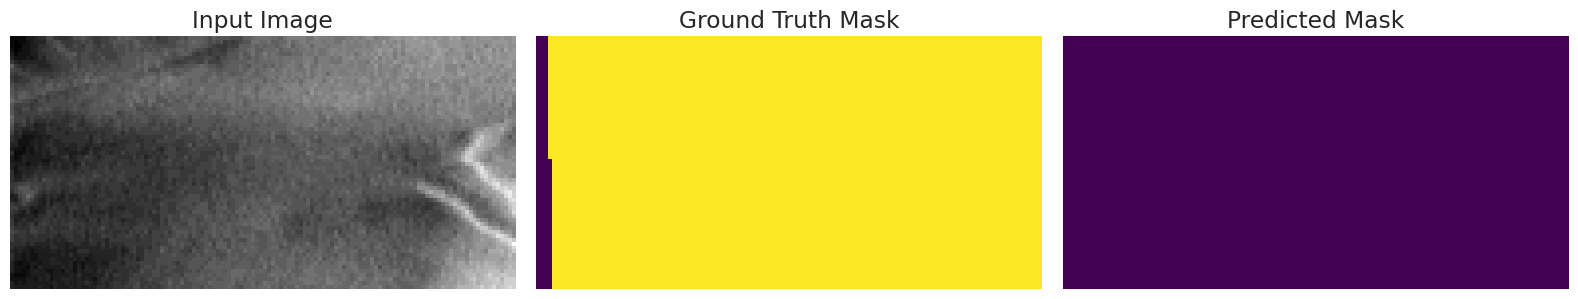

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.6953 - loss: 0.0081 - meaniou: 0.6575 - val_accuracy: 0.5945 - val_loss: 0.5211 - val_meaniou: 0.5221 - learning_rate: 0.0010
Epoch 27/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.6874 - loss: 0.0083 - meaniou: 0.6425 - val_accuracy: 0.6687 - val_loss: 0.4570 - val_meaniou: 0.6132 - learning_rate: 0.0010
Epoch 28/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.6929 - loss: 0.0081 - meaniou: 0.6538 - val_accuracy: 0.6648 - val_loss: 0.4513 - val_meaniou: 0.6215 - learning_rate: 0.0010
Epoch 29/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.6952 - loss: 0.0081 - meaniou: 0.6695 - val_accuracy: 0.6707 - val_loss: 0.4637 - val_meaniou: 0.5932 - learning_rate: 0.0010
Epoch 30/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.6947 - loss: 0.0080 - meaniou: 0.6640 - val_accuracy: 0.6475 - val_loss: 0.4763 - val_meaniou: 0.5928 - learning_rate: 0.0010
Epoch 31/1000
106/106 ━━

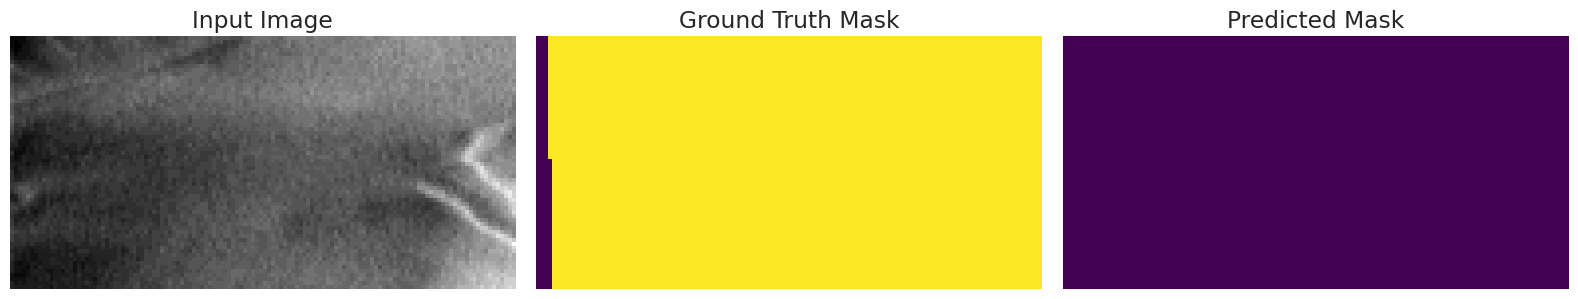

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.6969 - loss: 0.0080 - meaniou: 0.6680 - val_accuracy: 0.6077 - val_loss: 0.5423 - val_meaniou: 0.5189 - learning_rate: 0.0010
Epoch 32/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.6939 - loss: 0.0080 - meaniou: 0.6719 - val_accuracy: 0.6475 - val_loss: 0.4734 - val_meaniou: 0.6155 - learning_rate: 0.0010
Epoch 33/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.6977 - loss: 0.0079 - meaniou: 0.6874 - val_accuracy: 0.6213 - val_loss: 0.5042 - val_meaniou: 0.5725 - learning_rate: 0.0010
Epoch 34/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7030 - loss: 0.0077 - meaniou: 0.7081 - val_accuracy: 0.6568 - val_loss: 0.4698 - val_meaniou: 0.6022 - learning_rate: 0.0010
Epoch 35/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.7057 - loss: 0.0076 - meaniou: 0.6946 - val_accuracy: 0.6815 - val_loss: 0.4374 - val_meaniou: 0.6420 - learning_rate: 0.0010
Epoch 36/1000
106/106 ━━

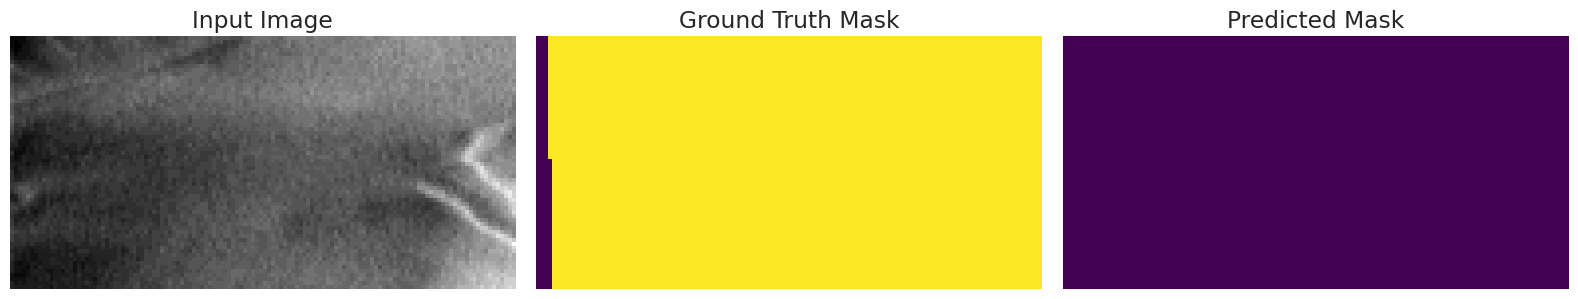

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.7062 - loss: 0.0076 - meaniou: 0.7025 - val_accuracy: 0.6891 - val_loss: 0.4248 - val_meaniou: 0.6829 - learning_rate: 0.0010
Epoch 37/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.7080 - loss: 0.0075 - meaniou: 0.7133 - val_accuracy: 0.5466 - val_loss: 0.5996 - val_meaniou: 0.4448 - learning_rate: 0.0010
Epoch 38/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.6854 - loss: 0.0082 - meaniou: 0.6475 - val_accuracy: 0.6608 - val_loss: 0.4606 - val_meaniou: 0.6194 - learning_rate: 0.0010
Epoch 39/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7047 - loss: 0.0076 - meaniou: 0.7075 - val_accuracy: 0.6792 - val_loss: 0.4399 - val_meaniou: 0.6678 - learning_rate: 0.0010
Epoch 40/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7120 - loss: 0.0074 - meaniou: 0.7216 - val_accuracy: 0.6947 - val_loss: 0.4110 - val_meaniou: 0.6999 - learning_rate: 0.0010
Epoch 41/1000
106/106 ━━

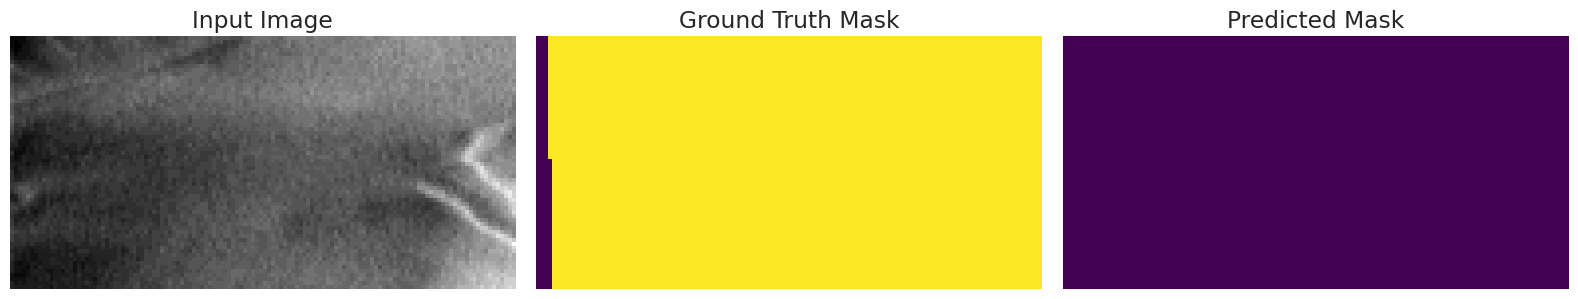

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.7127 - loss: 0.0073 - meaniou: 0.7270 - val_accuracy: 0.6981 - val_loss: 0.4117 - val_meaniou: 0.7090 - learning_rate: 0.0010
Epoch 42/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7089 - loss: 0.0075 - meaniou: 0.6989 - val_accuracy: 0.5910 - val_loss: 0.5339 - val_meaniou: 0.5094 - learning_rate: 0.0010
Epoch 43/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7000 - loss: 0.0076 - meaniou: 0.6965 - val_accuracy: 0.6845 - val_loss: 0.4316 - val_meaniou: 0.6649 - learning_rate: 0.0010
Epoch 44/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.6991 - loss: 0.0077 - meaniou: 0.6733 - val_accuracy: 0.6574 - val_loss: 0.4655 - val_meaniou: 0.6387 - learning_rate: 0.0010
Epoch 45/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.7139 - loss: 0.0071 - meaniou: 0.7236 - val_accuracy: 0.6732 - val_loss: 0.4367 - val_meaniou: 0.6674 - learning_rate: 0.0010
Epoch 46/1000
106/106 ━━

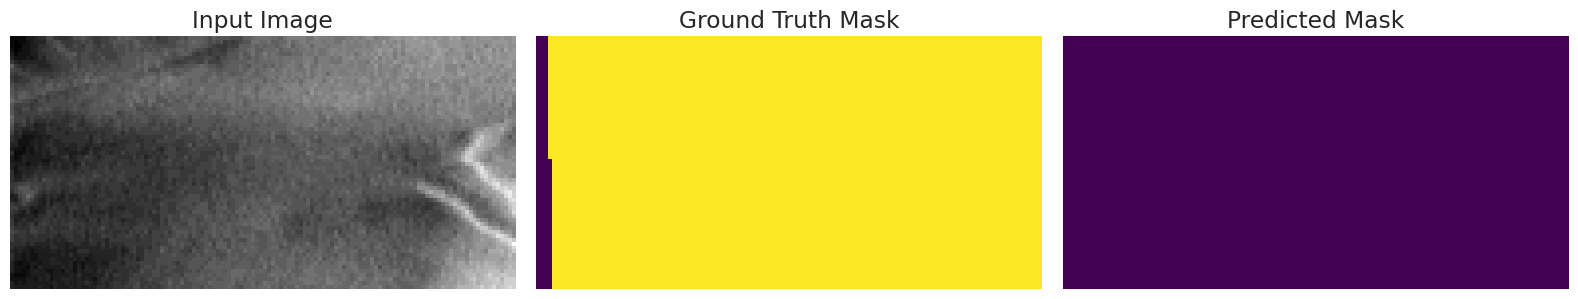

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.7129 - loss: 0.0071 - meaniou: 0.7200 - val_accuracy: 0.6287 - val_loss: 0.4971 - val_meaniou: 0.5757 - learning_rate: 0.0010
Epoch 47/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7071 - loss: 0.0073 - meaniou: 0.7027 - val_accuracy: 0.6684 - val_loss: 0.4509 - val_meaniou: 0.6349 - learning_rate: 0.0010
Epoch 48/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.7136 - loss: 0.0069 - meaniou: 0.7469 - val_accuracy: 0.6947 - val_loss: 0.4053 - val_meaniou: 0.7132 - learning_rate: 0.0010
Epoch 49/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7062 - loss: 0.0072 - meaniou: 0.6982 - val_accuracy: 0.6957 - val_loss: 0.4100 - val_meaniou: 0.7050 - learning_rate: 0.0010
Epoch 50/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7166 - loss: 0.0068 - meaniou: 0.7236 - val_accuracy: 0.6926 - val_loss: 0.4180 - val_meaniou: 0.6945 - learning_rate: 0.0010
Epoch 51/1000
106/106 ━━

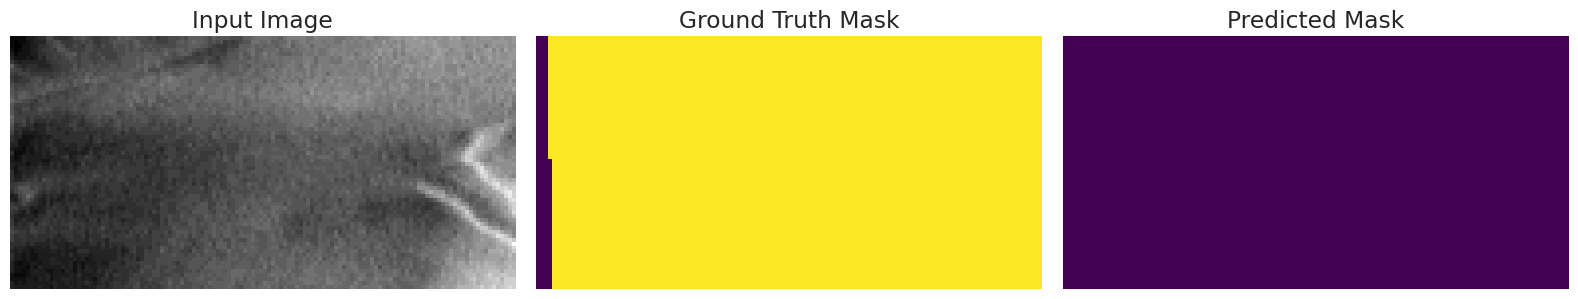

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.7220 - loss: 0.0065 - meaniou: 0.6269 - val_accuracy: 0.6908 - val_loss: 0.4215 - val_meaniou: 0.5508 - learning_rate: 0.0010
Epoch 52/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7268 - loss: 0.0063 - meaniou: 0.6278 - val_accuracy: 0.7177 - val_loss: 0.4144 - val_meaniou: 0.5514 - learning_rate: 0.0010
Epoch 53/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7508 - loss: 0.0064 - meaniou: 0.6118 - val_accuracy: 0.6761 - val_loss: 0.5041 - val_meaniou: 0.4294 - learning_rate: 0.0010
Epoch 54/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7632 - loss: 0.0067 - meaniou: 0.5881 - val_accuracy: 0.7308 - val_loss: 0.4352 - val_meaniou: 0.5206 - learning_rate: 0.0010
Epoch 55/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.7746 - loss: 0.0064 - meaniou: 0.5957 - val_accuracy: 0.7149 - val_loss: 0.4529 - val_meaniou: 0.5076 - learning_rate: 0.0010
Epoch 56/1000
106/106 ━━

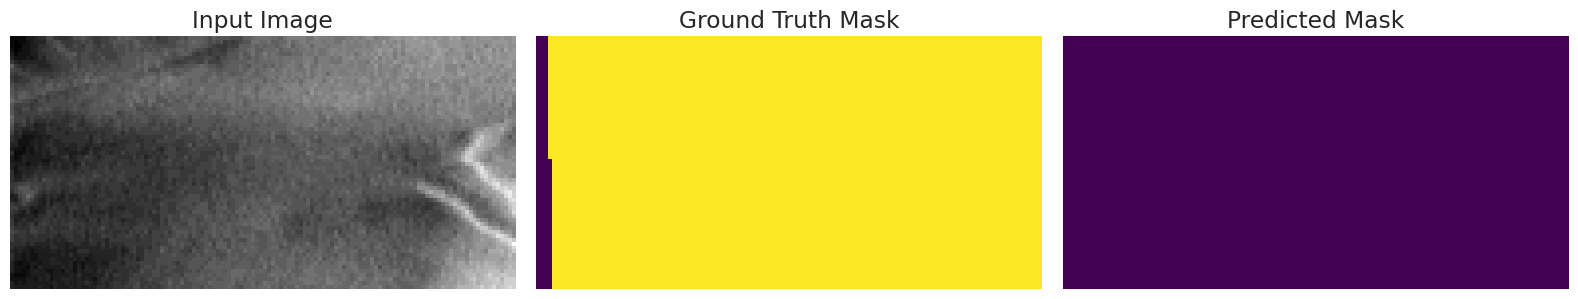

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.7915 - loss: 0.0061 - meaniou: 0.6191 - val_accuracy: 0.7526 - val_loss: 0.3971 - val_meaniou: 0.5640 - learning_rate: 0.0010
Epoch 57/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7960 - loss: 0.0059 - meaniou: 0.6265 - val_accuracy: 0.7494 - val_loss: 0.4129 - val_meaniou: 0.5393 - learning_rate: 0.0010
Epoch 58/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7963 - loss: 0.0059 - meaniou: 0.6209 - val_accuracy: 0.7742 - val_loss: 0.4071 - val_meaniou: 0.5035 - learning_rate: 0.0010
Epoch 59/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7952 - loss: 0.0060 - meaniou: 0.6117 - val_accuracy: 0.7709 - val_loss: 0.4018 - val_meaniou: 0.5130 - learning_rate: 0.0010
Epoch 60/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7957 - loss: 0.0061 - meaniou: 0.6067 - val_accuracy: 0.7505 - val_loss: 0.4123 - val_meaniou: 0.5391 - learning_rate: 0.0010
Epoch 61/1000
106/106 ━━

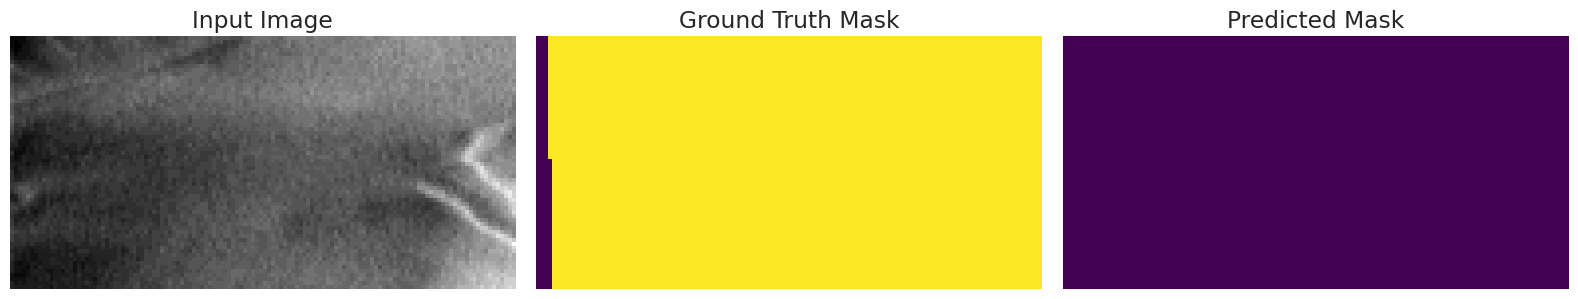

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.8017 - loss: 0.0058 - meaniou: 0.6293 - val_accuracy: 0.7254 - val_loss: 0.4498 - val_meaniou: 0.5032 - learning_rate: 0.0010
Epoch 62/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.8008 - loss: 0.0059 - meaniou: 0.6170 - val_accuracy: 0.7683 - val_loss: 0.3846 - val_meaniou: 0.5698 - learning_rate: 0.0010
Epoch 63/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8068 - loss: 0.0057 - meaniou: 0.6286 - val_accuracy: 0.7274 - val_loss: 0.4403 - val_meaniou: 0.5211 - learning_rate: 0.0010
Epoch 64/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8017 - loss: 0.0058 - meaniou: 0.6218 - val_accuracy: 0.7607 - val_loss: 0.4093 - val_meaniou: 0.5343 - learning_rate: 0.0010
Epoch 65/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8031 - loss: 0.0058 - meaniou: 0.6213 - val_accuracy: 0.7342 - val_loss: 0.4365 - val_meaniou: 0.5235 - learning_rate: 0.0010
Epoch 66/1000
106/106 ━━

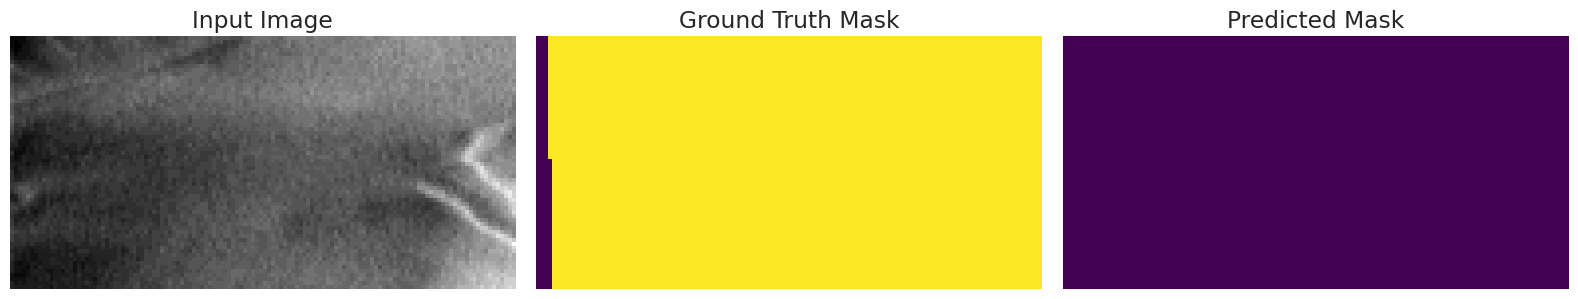

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.8085 - loss: 0.0057 - meaniou: 0.6238 - val_accuracy: 0.7262 - val_loss: 0.4357 - val_meaniou: 0.5279 - learning_rate: 0.0010
Epoch 67/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8035 - loss: 0.0060 - meaniou: 0.6003 - val_accuracy: 0.6949 - val_loss: 0.4820 - val_meaniou: 0.4868 - learning_rate: 0.0010
Epoch 68/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8081 - loss: 0.0056 - meaniou: 0.6248 - val_accuracy: 0.7159 - val_loss: 0.4931 - val_meaniou: 0.4415 - learning_rate: 0.0010
Epoch 69/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8117 - loss: 0.0056 - meaniou: 0.6347 - val_accuracy: 0.7361 - val_loss: 0.4406 - val_meaniou: 0.5139 - learning_rate: 2.0000e-04
Epoch 70/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.8210 - loss: 0.0054 - meaniou: 0.6374 - val_accuracy: 0.7610 - val_loss: 0.4104 - val_meaniou: 0.5294 - learning_rate: 2.0000e-04
Epoch 71/1000
10

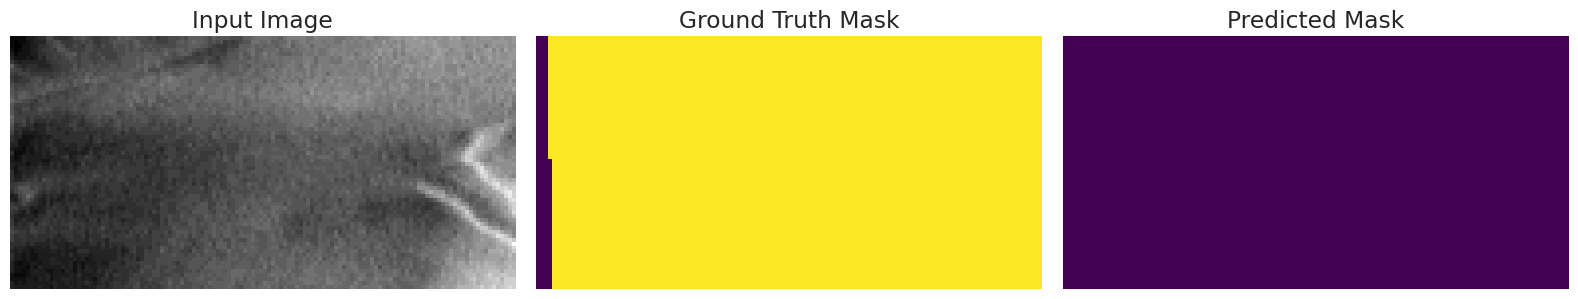

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.8255 - loss: 0.0053 - meaniou: 0.6460 - val_accuracy: 0.7662 - val_loss: 0.4081 - val_meaniou: 0.5265 - learning_rate: 2.0000e-04
Epoch 72/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8269 - loss: 0.0052 - meaniou: 0.6464 - val_accuracy: 0.7587 - val_loss: 0.4166 - val_meaniou: 0.5213 - learning_rate: 2.0000e-04
Epoch 73/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8292 - loss: 0.0052 - meaniou: 0.6491 - val_accuracy: 0.7680 - val_loss: 0.4041 - val_meaniou: 0.5342 - learning_rate: 2.0000e-04
Epoch 74/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8315 - loss: 0.0052 - meaniou: 0.6491 - val_accuracy: 0.7634 - val_loss: 0.4084 - val_meaniou: 0.5302 - learning_rate: 2.0000e-04
Epoch 75/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8322 - loss: 0.0052 - meaniou: 0.6516 - val_accuracy: 0.7636 - val_loss: 0.4117 - val_meaniou: 0.5243 - learning_rate: 2.0000e-04
Epoc

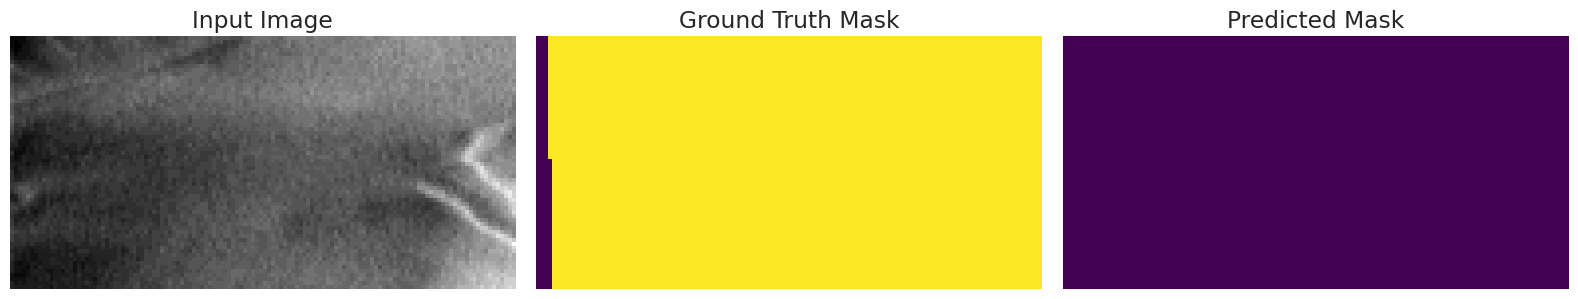

106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.8337 - loss: 0.0051 - meaniou: 0.6516 - val_accuracy: 0.7714 - val_loss: 0.4018 - val_meaniou: 0.5300 - learning_rate: 2.0000e-04
Epoch 77/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.8352 - loss: 0.0051 - meaniou: 0.6517 - val_accuracy: 0.7742 - val_loss: 0.3958 - val_meaniou: 0.5441 - learning_rate: 2.0000e-04
Epoch 78/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.8356 - loss: 0.0051 - meaniou: 0.6526 - val_accuracy: 0.7654 - val_loss: 0.4110 - val_meaniou: 0.5233 - learning_rate: 2.0000e-04
Final validation Mean Intersection Over Union: 71.32%
Model saved to model_241210_190925.keras


In [ ]:
# Compile model
model.compile(
    loss=loss1,
    optimizer=optimizer,
    metrics=metrics
)

# Train the model
history = model.fit(
    train_img,
    train_lbl_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    sample_weight=sample_weights,
    validation_data=(val_img, val_lbl_cat),
    callbacks=[early_stopping, viz_callback, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_meaniou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [ ]:
model.save('model1.keras')
print(f"Model saved to model1.keras")

Model saved to model1.keras


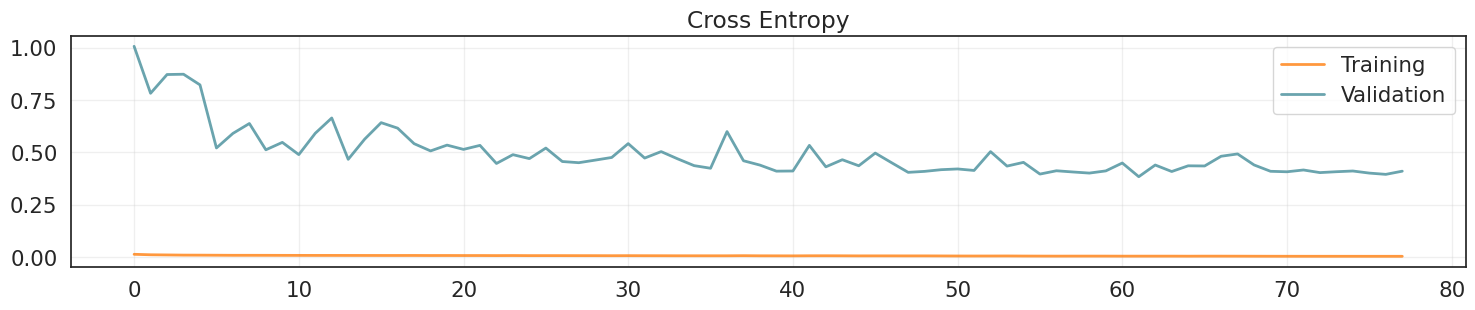

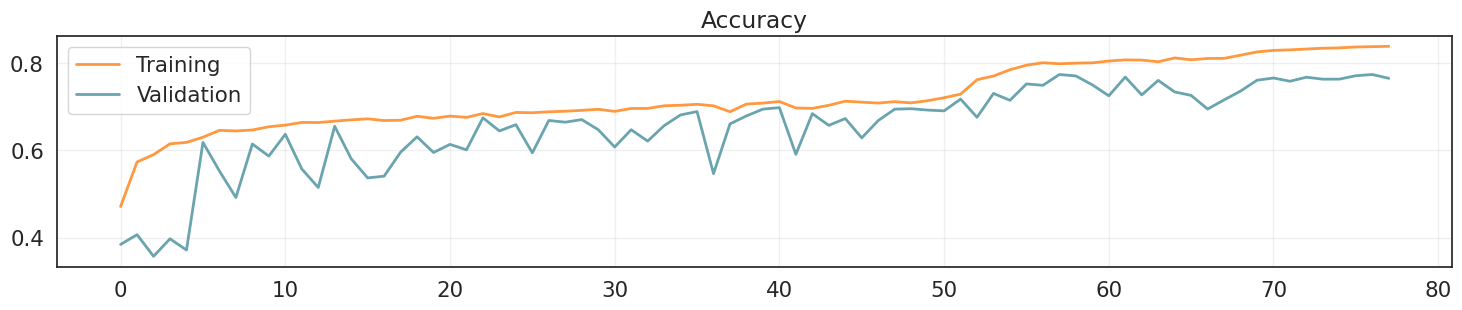

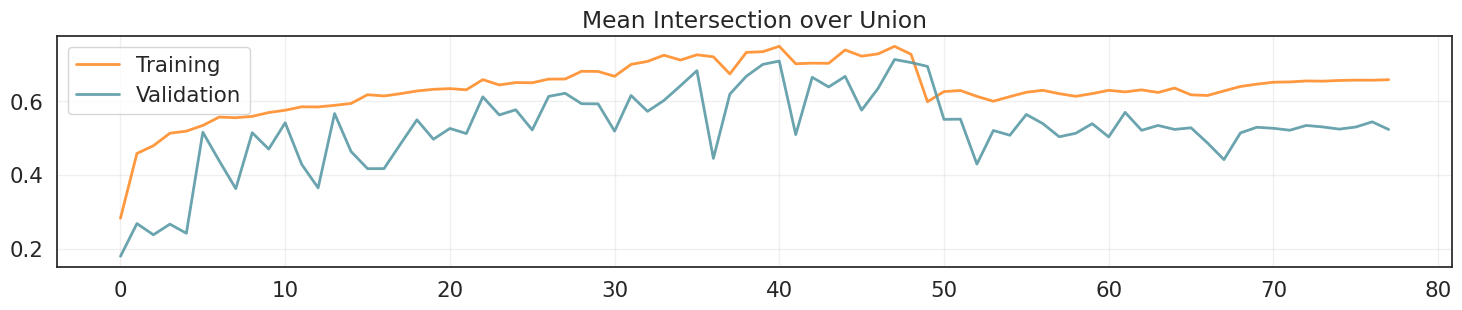

In [ ]:
plot_training_history(history)

In [ ]:
val_lbl_pred = model.predict(val_img)

y_pred_argmax = np.argmax(val_lbl_pred, axis=-1)  # Convert one-hot predictions to class indices
val_lbl_argmax = np.argmax(val_lbl_cat, axis=-1)  # Convert one-hot labels to class indices

miou_per_class = calculate_classwise_miou(val_lbl_argmax, y_pred_argmax, num_classes)

# Print the IoU scores for each class
print("Class-wise IoU scores:")
for cls, score in miou_per_class.items():
    print(f"{cls}: {score:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class-wise IoU scores:
Class 0: nan
Class 1: 0.8558
Class 2: 0.8084
Class 3: 0.8655
Class 4: 0.3231


<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it